In [1]:
import pandas as pd

# Load the uploaded CSV files to check their structure and contents
file_path_projections = "C:/Users/user/Desktop/학부 연구생/프로젝트/archive/indiana_projections.csv"
file_path_reports ="C:/Users/user/Desktop/학부 연구생/프로젝트/archive/indiana_reports.csv"


# Read the CSV files
data_projections = pd.read_csv(file_path_projections)
data_reports = pd.read_csv(file_path_reports)
# Filter for "Frontal" images in the projections dataset
frontal_data = data_projections[data_projections['projection'] == 'Frontal']

# Merge the frontal data with the reports data using 'uid' as the key
merged_data = pd.merge(frontal_data, data_reports, on='uid', how='inner')

# Check the resulting merged data
merged_data.head()


,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,4_IM-2050-1001.dcm.png,Frontal,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,5_IM-2117-1003002.dcm.png,Frontal,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [2]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
from torch.utils.data import DataLoader, Dataset
# findings와 impression 결합
merged_data["report"] = merged_data["findings"].fillna("") + " " + merged_data["impression"].fillna("")
merged_data["report"] = merged_data["report"].str.strip()

# 필요한 컬럼 선택 및 NaN 제거
merged_data = merged_data[["uid", "filename", "projection", "indication", "report"]].dropna()

# BERT Tokenizer 로드 (BioBERT로 변경)
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# MLM 데이터셋 클래스 정의
class MLM_Dataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        
        # BERT 토크나이징
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [3]:
from transformers import BertForSequenceClassification

# 모델 로드 (BioBERT로 변경)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)

# 데이터셋 및 DataLoader 생성
mlm_dataset = MLM_Dataset(merged_data["report"].tolist() + merged_data["indication"].tolist(), tokenizer)
mlm_dataloader = DataLoader(mlm_dataset, batch_size=8, shuffle=True)


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [12]:
import random
import torch

# 'report' 컬럼에서 'XXXX' 제외한 텍스트를 필터링
filtered_texts = [text for text in merged_data["report"].dropna() if "XXXX" not in text]

# 랜덤 샘플 선택 (filtered_texts가 비어 있으면 기본값 제공)
sample_text = random.choice(filtered_texts) if filtered_texts else "No valid text found."

# 텍스트에서 'XXXX' 제외한 단어들만 선택
words = sample_text.split()
candidate_indices = [i for i, word in enumerate(words) if word != "XXXX" and "." not in word and "," not in word]

# 랜덤으로 3개의 단어 마스킹
mask_count = min(3, len(candidate_indices))  # 최소 3개 단어 마스킹, 후보 단어가 3개 미만이면 그 수만큼 마스크
mask_indices = random.sample(candidate_indices, mask_count)

# 마스킹 수행
masked_text = words[:]
for idx in mask_indices:
    masked_text[idx] = tokenizer.mask_token  # [MASK] 토큰 적용

masked_text = " ".join(masked_text)

# 토크나이징 및 텐서 변환
inputs = tokenizer(masked_text, return_tensors="pt").to(device)
mask_idx = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]

# MLM 예측 수행
with torch.no_grad():
    predictions = model(**inputs).logits

# 실제 단어 인덱스 추출
actual_words = [words[i] for i in mask_indices]

# 마스크된 토큰 예측 및 복원
# 마스크된 토큰 예측 및 복원
predicted_text = masked_text
correct_predictions = 0
for idx in mask_idx.tolist():
    predicted_token = tokenizer.decode(torch.argmax(predictions[0, idx]).item()).strip().lower()  # 예측된 토큰
    actual_word = actual_words[mask_idx.tolist().index(idx)].strip().lower()  # 실제 단어
    
    # 예측된 토큰에서 불필요한 기호나 공백 제거
    predicted_token = predicted_token.replace(",", "").replace(".", "").strip()

    # 예측이 실제 단어와 일치하면 정확도 증가
    if predicted_token == actual_word:
        correct_predictions += 1

    # 예측된 단어로 텍스트를 업데이트
    predicted_text = predicted_text.replace(tokenizer.mask_token, predicted_token, 1)


# 결과 출력
print("=" * 50)
print("📝 원본 텍스트:\n", sample_text, "\n", "=" * 50)
print("\n🔍 마스킹된 텍스트:\n", masked_text, "\n", "=" * 50)
print("\n🎯 예측된 텍스트:\n", predicted_text, "\n", "=" * 50)




📝 원본 텍스트:
 The cardiomediastinal silhouette and vasculature are within normal limits for size and contour. The lungs are normally inflated and clear. Osseous structures are within normal limits for patient age. 1. No acute radiographic cardiopulmonary process. 

🔍 마스킹된 텍스트:
 The cardiomediastinal silhouette and vasculature are [MASK] normal limits for size and contour. The lungs [MASK] normally inflated and clear. Osseous [MASK] are within normal limits for patient age. 1. No acute radiographic cardiopulmonary process. 

🎯 예측된 텍스트:
 The cardiomediastinal silhouette and vasculature are within normal limits for size and contour. The lungs are normally inflated and clear. Osseous structures are within normal limits for patient age. 1. No acute radiographic cardiopulmonary process. 


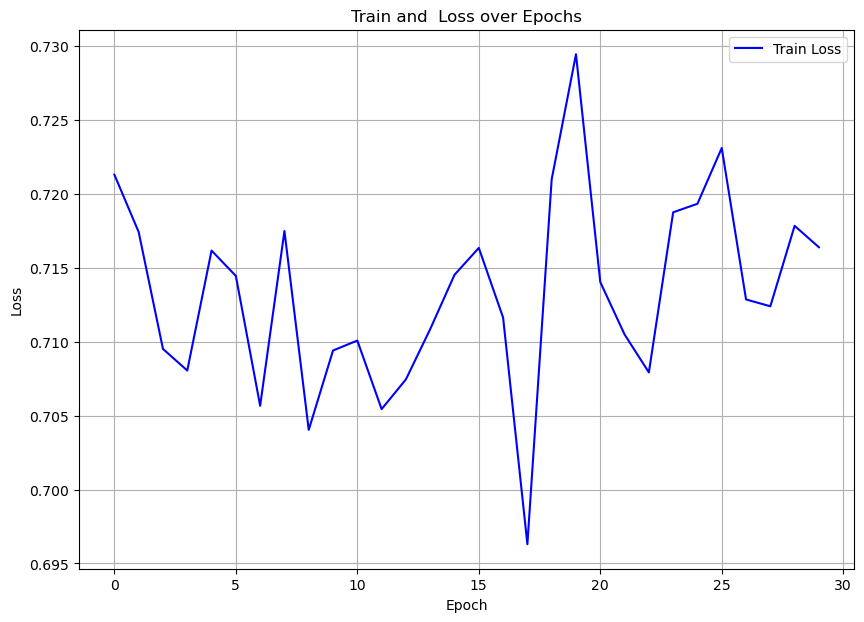

In [14]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 'report' 컬럼에서 'XXXX' 제외한 텍스트를 필터링
filtered_texts = [text for text in merged_data["report"].dropna() if "XXXX" not in text]

# 랜덤으로 500개의 텍스트 샘플 선택
sample_texts = random.sample(filtered_texts, 50) if len(filtered_texts) >= 1000 else filtered_texts

# loss 값들을 저장할 리스트
train_losses = []

N_EPOCHS = 30 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 각 텍스트에 대해 예측 및 loss 계산
for epoch in range(N_EPOCHS):  # 각 epoch 반복
    epoch_train_losses = []  # epoch 내 train loss를 저장할 리스트

    for sample_text in sample_texts:
        # 텍스트에서 'XXXX' 제외한 단어들만 선택
        words = sample_text.split()
        candidate_indices = [i for i, word in enumerate(words) if word != "XXXX" and "." not in word and "," not in word]

        # 텍스트에서 15%에 해당하는 단어 마스킹
        mask_count = max(1, int(len(candidate_indices) * 0.15))  # 최소 1개 단어 마스킹, 15%의 단어 마스크
        mask_indices = random.sample(candidate_indices, mask_count)

        # 마스킹 수행
        masked_text = words[:]
        for idx in mask_indices:
            masked_text[idx] = tokenizer.mask_token  # [MASK] 토큰 적용

        masked_text = " ".join(masked_text)

        # 토크나이징 및 텐서 변환
        inputs = tokenizer(masked_text, return_tensors="pt").to(device)
        mask_idx = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]

        # MLM 예측 수행
        with torch.no_grad():
            outputs = model(**inputs)

        predictions = outputs.logits  # 예측 결과
        labels = inputs.input_ids.clone()  # labels는 입력 텍스트와 동일, 마스크된 부분만 제외

        # 마스크된 부분은 loss 계산에서 제외
        labels[inputs.input_ids == tokenizer.mask_token_id] = -100

        # loss 계산
        loss = F.cross_entropy(predictions.view(-1, predictions.size(-1)), labels.view(-1), ignore_index=-100)

        # epoch 내 loss 저장
        epoch_train_losses.append(loss.item())

    # Epoch별 평균 train loss 계산
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

# loss 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(range(N_EPOCHS), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and  Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
